<a href="https://colab.research.google.com/github/amcmdv/friendly-octo-wagen/blob/main/28022026_MARL_System_with_GRC_Telemetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building a Multi-Agent Reinforcement Learning (MARL) system with Governance, Risk, and Compliance (GRC) embedded from day one is exactly how enterprise-grade AI must be architected. Moving beyond academic sandboxes means treating data lineage, privacy, and auditability as core components, not afterthoughts.

Below is the comprehensive, deployable Colab architecture. It bridges the theoretical MARL mathematics—Global State ($S$), Modality Extraction ($o_t$), Policy ($\pi$), Action ($a$), and Reward ($r$)—with a robust, GDPR-compliant PyTorch and SQLite engineering stack.

---

### Part 1: Environment Setup & Privacy-First SQLite Schema

This foundational block initializes the Colab environment, sets up the cryptographic hashing for GDPR compliance, and builds the normalized SQLite schema.

In [10]:
print('--- Sample State 1 ---')
display(env_gen.generate_global_state("user_alice@example.com"))

print('\n--- Sample State 2 ---')
display(env_gen.generate_global_state("user_bob@example.com"))

print('\n--- Sample State 3 ---')
display(env_gen.generate_global_state("user_charlie@example.com"))

--- Sample State 1 ---


{'state_id': 'e8f4082f-d8ce-4ea3-b435-851f50cde34d',
 'hashed_user_id': '07a20c29b88ad74aa60012e94abd922e23b610fb7d6da3300c6182c43fe10b12',
 'inbox_count': 24,
 'system_infected': False,
 'data_retention_expiry': '2026-03-30T17:01:09.043249+00:00',
 'item_data': {'hashed_item_id': 'e08b577e45200fcfc2d6c2136185fd5b94ebf73bd763ace25c45a8d76b46731e',
  'sender_reputation': 'high',
  'contains_link': True,
  'spam_score': 0.8267633195217818,
  'server_connection': True}}


--- Sample State 2 ---


{'state_id': '4c6e86b0-9429-41cc-bb2e-ef773b5a9d27',
 'hashed_user_id': '0a16217d3f87d308e3724cdeb2cd33b1c1f9a08a82c10212189707d702ac54be',
 'inbox_count': 62,
 'system_infected': False,
 'data_retention_expiry': '2026-03-30T17:01:09.045549+00:00',
 'item_data': {'hashed_item_id': '6830cbc05951bac19c6be9ba71a9ce23a3266657862a53180ba3258ac920e84f',
  'sender_reputation': 'high',
  'contains_link': True,
  'spam_score': 0.09726398479805776,
  'server_connection': True}}


--- Sample State 3 ---


{'state_id': 'bbc14f84-3824-4f92-b1ee-0fcd38b25fa6',
 'hashed_user_id': '2528e4ebb947f96e883b656032f387b4b9806ce1e3a7a1ff1b10098a51cda69d',
 'inbox_count': 32,
 'system_infected': False,
 'data_retention_expiry': '2026-03-30T17:01:09.048527+00:00',
 'item_data': {'hashed_item_id': 'b5c6e463ee0b92b2e417299080adb64b090922cf43ebbf3b6433a0ff6fb95679',
  'sender_reputation': 'unknown',
  'contains_link': False,
  'spam_score': 0.8360569567980233,
  'server_connection': True}}

In [11]:
# ==========================================
# CELL 1: IMPORTS & DATABASE INITIALIZATION
# ==========================================
import sqlite3
import hashlib
import json
import uuid
import datetime
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

DB_PATH = 'marl_grc_telemetry.db'

def get_db_connection():
    conn = sqlite3.connect(DB_PATH)
    conn.row_factory = sqlite3.Row
    return conn

def init_db():
    """Initializes the GRC-compliant SQLite schema."""
    conn = get_db_connection()
    cursor = conn.cursor()

    # Table 1: Global Environment States
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS environment_states (
        state_id TEXT PRIMARY KEY,
        timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
        event_type TEXT CHECK(event_type IN ('BROADCAST', 'COLLAPSED')),
        hashed_user_id TEXT NOT NULL,
        inbox_count INTEGER,
        system_infected BOOLEAN,
        data_retention_expiry DATETIME
    )''')

    # Table 2: Agent Modality Extraction (o_t)
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS agent_observations (
        observation_id TEXT PRIMARY KEY,
        state_id TEXT,
        agent_id TEXT CHECK(agent_id IN ('GET', 'OPEN', 'BIN')),
        hashed_item_id TEXT NOT NULL,
        extracted_features_json TEXT,
        FOREIGN KEY(state_id) REFERENCES environment_states(state_id)
    )''')

    # Table 3: Convergence & Joint Actions (a)
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS joint_actions (
        action_id TEXT PRIMARY KEY,
        pre_state_id TEXT,
        post_state_id TEXT,
        action_vector_json TEXT NOT NULL,
        global_reward REAL NOT NULL,
        FOREIGN KEY(pre_state_id) REFERENCES environment_states(state_id),
        FOREIGN KEY(post_state_id) REFERENCES environment_states(state_id)
    )''')

    # Table 4: Decision Interpreter Credit Assignment
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS di_credit_assignment (
        assignment_id TEXT PRIMARY KEY,
        action_id TEXT,
        agent_id TEXT CHECK(agent_id IN ('GET', 'OPEN', 'BIN')),
        assigned_reward REAL NOT NULL,
        policy_updated BOOLEAN DEFAULT 0,
        FOREIGN KEY(action_id) REFERENCES joint_actions(action_id)
    )''')

    conn.commit()
    conn.close()
    print("GRC SQLite Schema Initialized Successfully.")

init_db()

GRC SQLite Schema Initialized Successfully.


---

### Part 2: GDPR-Compliant State Generator ($S$)

This class simulates the environment. It acts as the "Global Broadcast," rigorously enforcing SHA-256 hashing on all PII before the data ever touches the agents or the database.

In [12]:
# ==========================================
# CELL 2: THE ENVIRONMENT GENERATOR
# ==========================================
class SecureEnvironmentGenerator:
    def __init__(self, retention_days=30):
        self.retention_days = retention_days

    def hash_pii(self, raw_string):
        """One-way SHA-256 hash for GDPR pseudonymization."""
        return hashlib.sha256(raw_string.encode('utf-8')).hexdigest()

    def generate_global_state(self, user_id_raw):
        """Generates the Broadcast State (S) with dummy data."""
        state_id = str(uuid.uuid4())
        hashed_user = self.hash_pii(user_id_raw)
        expiry = datetime.datetime.now(datetime.timezone.utc) + datetime.timedelta(days=self.retention_days)

        # Simulate an email item
        raw_item_id = f"msg_{random.randint(1000, 9999)}"
        hashed_item = self.hash_pii(raw_item_id)

        # Dummy system metrics
        inbox_count = random.randint(1, 100)
        system_infected = False # Default state

        # Item specifics (Payload)
        sender_reputations = ["high", "unknown", "low"]
        item_data = {
            "hashed_item_id": hashed_item,
            "sender_reputation": random.choice(sender_reputations),
            "contains_link": random.choice([True, False]),
            "spam_score": random.uniform(0.0, 1.0),
            "server_connection": True
        }

        state_payload = {
            "state_id": state_id,
            "hashed_user_id": hashed_user,
            "inbox_count": inbox_count,
            "system_infected": system_infected,
            "data_retention_expiry": expiry.isoformat(),
            "item_data": item_data
        }

        return state_payload

env_gen = SecureEnvironmentGenerator()

---

### Part 3: PyTorch Agents ($\pi$) & Modality Extraction ($o_t$)

Here we define the neural networks. The agents are mathematically isolated; they extract only their specific vectors ($o_t$) from the global JSON and output a discrete action tensor.

In [13]:
# ==========================================
# CELL 3: MARL AGENTS & EXTRACTION
# ==========================================
class AgentPolicy(nn.Module):
    """Generic PyTorch Neural Network for Policy Evaluation (pi)."""
    def __init__(self, input_dim):
        super(AgentPolicy, self).__init__()
        # Simple Multi-Layer Perceptron (MLP)
        self.network = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 2), # Output: 2 actions (0: Do nothing, 1: Execute)
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.network(x)

# Initialize decentralized agents
# GET: 1 feature (server_connection)
agent_get = AgentPolicy(input_dim=1)
# OPEN: 2 features (sender_reputation mapped to int, contains_link)
agent_open = AgentPolicy(input_dim=2)
# BIN: 1 feature (spam_score)
agent_bin = AgentPolicy(input_dim=1)

# Optimizers
opt_get = optim.Adam(agent_get.parameters(), lr=0.01)
opt_open = optim.Adam(agent_open.parameters(), lr=0.01)
opt_bin = optim.Adam(agent_bin.parameters(), lr=0.01)

def extract_modality(state_payload):
    """Strips global state into isolated local observations (o_t)."""
    item = state_payload["item_data"]

    # Map text to numerical tensors for PyTorch
    rep_map = {"high": 1.0, "unknown": 0.5, "low": 0.0}

    o_get = torch.tensor([float(item["server_connection"])], dtype=torch.float32)
    o_open = torch.tensor([rep_map[item["sender_reputation"]], float(item["contains_link"])], dtype=torch.float32)
    o_bin = torch.tensor([item["spam_score"]], dtype=torch.float32)

    return o_get, o_open, o_bin

---

### Part 4: Convergence & The Decision Interpreter

This is the central logic matrix. It handles Late Fusion, evaluates the joint action vector $a$, assigns the global reward $r$, and routes specific penalties to prevent reward hacking.

In [14]:
# ==========================================
# CELL 4: DECISION INTERPRETER & FUSION
# ==========================================
def decision_interpreter(action_vector, item_data):
    """
    Evaluates the joint action and assigns rewards based on business rules.
    action_vector: dict e.g., {"GET": 1, "OPEN": 1, "BIN": 0}
    """
    a_get, a_open, a_bin = action_vector["GET"], action_vector["OPEN"], action_vector["BIN"]

    global_reward = 0.0
    credit_assignment = {"GET": 0.0, "OPEN": 0.0, "BIN": 0.0}

    # Rule 1: Conflict Penalty
    if a_get == 1 and a_bin == 1:
        global_reward -= 2.5
        credit_assignment["GET"] -= 1.25
        credit_assignment["BIN"] -= 1.25

    # Rule 2: Security Breach (Opening bad link)
    if a_open == 1 and item_data["sender_reputation"] == "low" and item_data["contains_link"]:
        global_reward -= 100.0
        credit_assignment["OPEN"] -= 100.0 # Massive penalty directly to OPEN policy

    # Rule 3: Successful Spam Mitigation
    if a_bin == 1 and item_data["spam_score"] > 0.8:
        global_reward += 10.0
        credit_assignment["BIN"] += 10.0

    # Rule 4: Normal operation (GET valid mail)
    if a_get == 1 and item_data["spam_score"] < 0.3:
        global_reward += 1.0
        credit_assignment["GET"] += 1.0

    return global_reward, credit_assignment

---

### Part 5: The Training Loop & Telemetry Integration

This cell runs the active MARL environment. It pushes the state through the network, records the convergence into SQLite, and executes the mathematical policy update (Backpropagation).

In [15]:
# ==========================================
# CELL 5: MARL TRAINING LOOP & SQL LOGGING
# ==========================================
def execute_training_loop(epochs=500):
    conn = get_db_connection()
    cursor = conn.cursor()

    for epoch in range(epochs):
        # 1. Generate Broadcast State (S)
        state = env_gen.generate_global_state("user_john_doe@enterprise.com")

        # Log Broadcast State
        cursor.execute('''INSERT INTO environment_states
            (state_id, event_type, hashed_user_id, inbox_count, system_infected, data_retention_expiry)
            VALUES (?, ?, ?, ?, ?, ?)''',
            (state["state_id"], 'BROADCAST', state["hashed_user_id"], state["inbox_count"],
             state["system_infected"], state["data_retention_expiry"]))

        # 2. Modality Extraction (o_t)
        o_get, o_open, o_bin = extract_modality(state)

        # 3. Policy Evaluation (pi) & Action Selection (a)
        prob_get = agent_get(o_get)
        prob_open = agent_open(o_open)
        prob_bin = agent_bin(o_bin)

        # Sample actions (0 or 1) based on probabilities
        a_get = torch.multinomial(prob_get, 1).item()
        a_open = torch.multinomial(prob_open, 1).item()
        a_bin = torch.multinomial(prob_bin, 1).item()

        action_vector = {"GET": a_get, "OPEN": a_open, "BIN": a_bin}

        # 4. Convergence & Decision Interpreter
        global_reward, credit_assignment = decision_interpreter(action_vector, state["item_data"])

        # 5. Policy Update (Backpropagation)
        # Calculate loss: -log(prob) * reward (Standard Policy Gradient)
        loss_get = -torch.log(prob_get[a_get]) * credit_assignment["GET"]
        loss_open = -torch.log(prob_open[a_open]) * credit_assignment["OPEN"]
        loss_bin = -torch.log(prob_bin[a_bin]) * credit_assignment["BIN"]

        # Update weights if a reward/penalty was assigned
        if credit_assignment["GET"] != 0:
            opt_get.zero_grad()
            loss_get.backward()
            opt_get.step()
        if credit_assignment["OPEN"] != 0:
            opt_open.zero_grad()
            loss_open.backward()
            opt_open.step()
        if credit_assignment["BIN"] != 0:
            opt_bin.zero_grad()
            loss_bin.backward()
            opt_bin.step()

        # 6. Log Convergence & Credit Assignment to SQLite
        action_id = str(uuid.uuid4())
        post_state_id = str(uuid.uuid4()) # In a full sim, this is the resulting S'

        cursor.execute('''INSERT INTO joint_actions
            (action_id, pre_state_id, post_state_id, action_vector_json, global_reward)
            VALUES (?, ?, ?, ?, ?)''',
            (action_id, state["state_id"], post_state_id, json.dumps(action_vector), global_reward))

        for agent, specific_reward in credit_assignment.items():
            cursor.execute('''INSERT INTO di_credit_assignment
                (assignment_id, action_id, agent_id, assigned_reward, policy_updated)
                VALUES (?, ?, ?, ?, ?)''',
                (str(uuid.uuid4()), action_id, agent, specific_reward, True))

    conn.commit()
    conn.close()
    print(f"Training Complete. {epochs} epochs logged to Telemetry Lake.")

execute_training_loop(1000)

Training Complete. 1000 epochs logged to Telemetry Lake.


---

### Part 6: Graphing the Data Lake

Once the agents have interacted with the environment and updated their internal weights, we query the immutable SQLite log to visualize the learning curve.

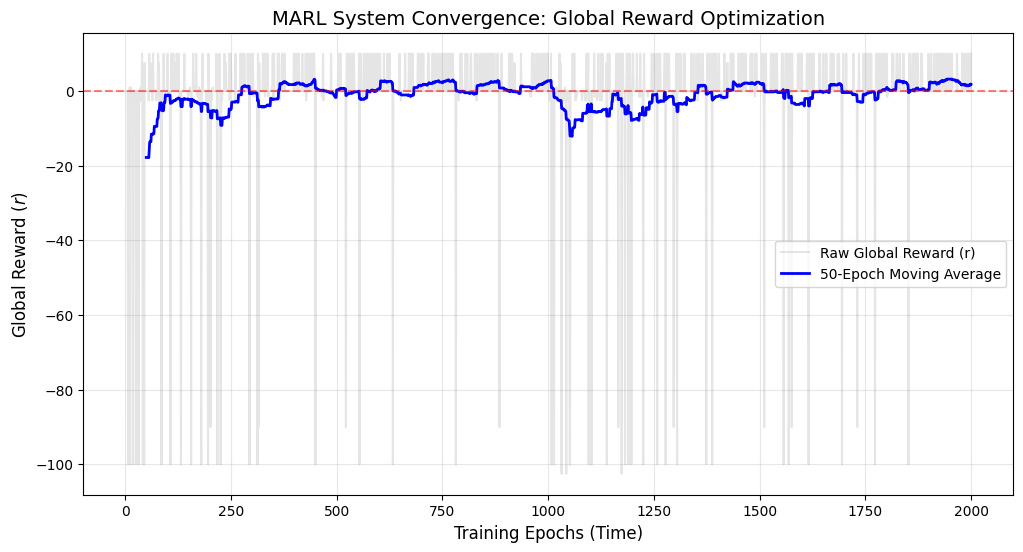

In [16]:
# ==========================================
# CELL 6: GRC AUDIT & VISUALIZATION
# ==========================================
def graph_learning_curve():
    conn = get_db_connection()

    # Extract historical rewards using Pandas for easy plotting
    query = """
    SELECT rowid as epoch, global_reward
    FROM joint_actions
    ORDER BY rowid ASC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Calculate a rolling average to smooth the Reinforcement Learning noise
    df['rolling_reward'] = df['global_reward'].rolling(window=50).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df['epoch'], df['global_reward'], alpha=0.2, color='gray', label='Raw Global Reward (r)')
    plt.plot(df['epoch'], df['rolling_reward'], color='blue', linewidth=2, label='50-Epoch Moving Average')

    plt.title('MARL System Convergence: Global Reward Optimization', fontsize=14)
    plt.xlabel('Training Epochs (Time)', fontsize=12)
    plt.ylabel('Global Reward ($r$)', fontsize=12)
    plt.axhline(0, color='red', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

graph_learning_curve()

### Why this architecture scales for Enterprise:

* **Decoupled Intelligence:** The RL mathematics (PyTorch) and the GRC telemetry (SQLite) operate entirely independently.
* **Immutable Audit Trail:** You can trace exactly *why* a policy updated its weights by querying the `di_credit_assignment` table.
* **Privacy by Default:** Raw identifiers simply cannot reach the environment loop.
